# Travail 1 - Kepler et Runge-Kutta 4 - Maxime Jamotte & Cédric Schoonen 

In [1]:
# Morceau de code utile pour calculer les temps d'exécutions

import time 

t0 = time.time()

## Introduction

Nous allons dans ce travail étudier la dynamique newtonienne du système Terre-Lune, en résolvant numériquement les équations de Newton. Nous prendrons pour conditions initiales dans le repère de la Terre que la Lune passe à son périgée ($362600000\,{\rm m}$) à une vitesse de $1083.4\,{\rm m/s}$. Nous vérifierons que la trajectoire est une ellipse et présenterons les paramètres calculés pour cette ellipse. Ensuite, nous nous intéresserons à l'ordre de convergence de la méthode utilisée. Enfin, nous étudierons la trajectoire d'un astéroïde qui traverse le centre de l'ellipse avec une vitesse $(v_x,v_y)=(-500\,{\rm m/s},500\,{\rm m/s})$ lorsque la Lune est à son apogée.

Toutes les grandeurs sont exprimées dans le système international d'unités (ceci est à considérer au cas où les unités ne seraient pas indiquées).

## Table des matières

- Système Terre-Lune
 - "Fonction d'évolution"
 - Paramètres et conditions initiales
 - Implémentation de Runge Kutta 4
 - Calcul de la trajectoire
 - Paramètres : grand et petit axes, excentricité et période
- Système Terre-Lune théorique
- Ordre de convergence
 - Calcul de l'ordre sur base des résultats numériques uniquement
 - Calcul de l'ordre par comparaison avec la théorie
- Système Terre-Lune-astéroïde
 - Calcul des trajectoires
 - Description de l'impact entre l'astéroïde et la Terre
- Animations
 - Animation des trajectoires pour le système Terre-Lune
 - Animation des trajectoires pour le système Terre-Lune-Astéroïde
- Investigations supplémentaires
 - Etude du passage de l'astéroïde près de la Terre
 - Trajectoire pour un astéroïde plus rapide
 - Ordre de convergence pour le méthode d'Euler
 - Ordre de convergence pour la méthode de Runge et Kutta d'ordre 2

## Système Terre - Lune

Nous nous occupons ici de calculer numériquement la trajectoire de la Lune dans le référentiel de la Terre. Nous utilisons pour cela la méthode de Runge-Kutta 4. 

Tout d'abord, importons les librairies utiles à notre travail.

In [2]:
import numpy
from math import log,sqrt
from matplotlib import pyplot
%matplotlib inline

### "Fonction d'évolution"

Cherchons l'expression des forces dans le référentiel de la Terre. Nous savons qu'une force gravitationnelle (force attractive) existe entre la Terre et la lune. Selon la loi de Newton, celle-ci s'écrit 

$${\bf F}_{L,T}=-{\bf F}_{T,L}=-Gm_T m_L\dfrac{{\bf x_L}-{\bf x_T}}{(x_L-x_T)^3}$$

pour deux masses $m_L$ et $m_T$ s'attirant avec des forces mutuellement opposées séparées d'une distance $r$ qui est la norme du vecteur partant du centre de la Terre jusqu'au centre de la lune. Nos conditions initiales étant données dans le repère de la Terre, nous allons résoudre les équations de Newton dans le repère de la Terre également. Nous avons donc besoin de reformuler notre équation avec comme variable le vecteur ${\bf r_{LT}} = {\bf x_L}-{\bf x_T}$. 

$$ {\bf \ddot{r}_{LT}} = {\bf \ddot{x}_L}-{\bf \ddot{x}_T} = \frac{1}{m_L}{\bf F}_{L,T} - \frac{1}{m_T}{\bf F}_{T,L} = -Gm_T \dfrac{{\bf x_L}-{\bf x_T}}{(x_L-x_T)^3} - Gm_L\dfrac{{\bf x_L}-{\bf x_T}}{(x_L-x_T)^3}$$

Ce qui devient

$$ {\bf \ddot{r}_{LT}} = -G(m_T+m_L)\dfrac{{\bf r_{LT}}}{r_{LT}^3} $$

Pour résoudre numériquement l'équation de Newton, qui est du deuxième ordre, nous allons la transformer en un système de deux équations du premier ordre. Pour ce faire, nous introduisons le vectreur $u_{LT} $ définit comme 

$$ u_{LT}  = \begin{pmatrix} x_{LT}\ , y_{LT}\ , v_{x\,LT}\ , v_{y\,LT}\end{pmatrix} $$

Notre système d'équations différentielles devient

$$ \dot{u}_{LT} = f(u_{LT}) $$ 

Il s'écrit avec une certaine "fonction d'évolution" $f$, donnée par

$$ f(u_{LT}) = \begin{pmatrix} v_{x\,LT}\ , v_{y\,LT}\ , -\dfrac{ m_T\, G\, x_{LT}}{ \left[x_{LT}^2 + y_{LT}^2\right]^{3/2}}\ , -\dfrac{ m_T\, G\, y_{LT}}{ \left[x_{LT}^2 + y_{LT}^2\right]^{3/2}}  \end{pmatrix} $$

Nous ne généraliserons pas la fonction $f$ à plus de deux corps, par soucis de lisibilité et car cela n'est pas nécessaire.

In [3]:
def f(uLT): 
    return numpy.array([uLT[2],\
                        uLT[3],\
                        -G*(mT+mL)*uLT[0]/(uLT[0]**2+uLT[1]**2)**(3/2),\
                        -G*(mT+mL)*uLT[1]/(uLT[0]**2+uLT[1]**2)**(3/2)])     

### Paramètres et conditions initiales

Ensuite, entrons les données caractéristiques du système. $T$ est la durée durant laquelle nous voulons simuler les trajectoires de la lune et de la Terre et $N$ est le paramètre qui définit le nombre de lignes des matrices de données de chaque astre.

In [4]:
T = 3600*24*30
dt = 1
N = 1+int(T/dt)

mT = 5.972*10**24
mL = 7.348*10**22
G = 6.67408*10**-11

Encodons à présent les conditions initiales. Nous nommons $dataLT$ la matrice de données de la lune dans le repère de la Terre. Elle comporte quatre colonnes. Chaque ligne se présentera comme $ u_{LT}  = \begin{pmatrix} x_{LT}\ , y_{LT}\ , v_{x\,LT}\ , v_{y\,LT}\end{pmatrix} $.

In [5]:
dataLT = numpy.empty((N,4)) 

uLT0 = [362600000,0,0,1083.4] #1083.4349740009823 (valeur pour une excentricité de 0.054900)

dataLT[0] = uLT0

### Implémentation de Runge Kutta 4

Nous avons ici la méthode Runge Kutta 4 appliquée à la trajectoire de la Lune.

In [6]:
def rk4(f,uLT,dt): 
    k1 = f(uLT)
    k2 = f(uLT+dt/2*k1)
    k3 = f(uLT+dt/2*k2)
    k4 = f(uLT+dt*k3)
    
    return uLT+dt/6*(k1+2*k2+2*k3+k4)

### Calcul de la trajectoire

Calculons maintenant la trajectoire. Notons que $dataLT[t]$ est le vecteur $u_{LT}$ input de $f$ au temps $t$.

In [7]:
for t in range(1,N):
    
    dataLT[t] = rk4(f,dataLT[t-1],dt)

Affichons la position de la Lune dans le repère de la Terre.

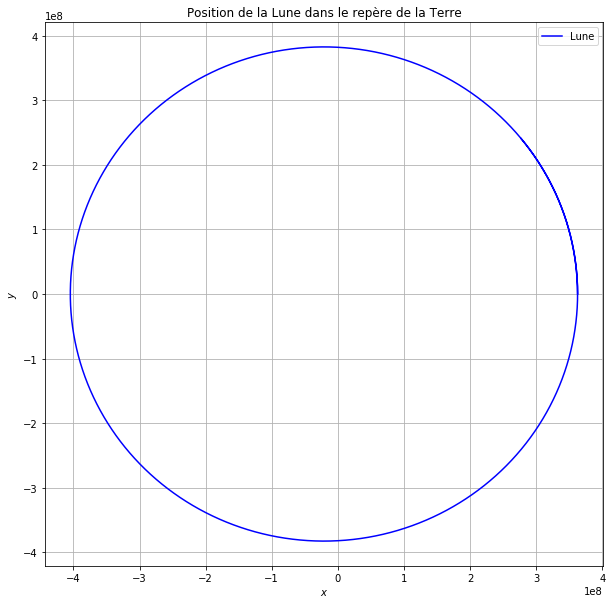

In [8]:
pyplot.figure(figsize=(10,10))
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.plot(dataLT[:,0],dataLT[:,1], 'b-', label='Lune')
pyplot.title('Position de la Lune dans le repère de la Terre')
pyplot.legend();
pyplot.show();

### Paramètres : grand et petit axes, excentricité et période

Calculons les paramètres de l'ellipse. Etant donné que la Lune commence sur l'axe $x$ avec une vitesse le long de $y$, les demi-grand axe $a$ et demi-petit axe $b$ sont alignés avec les axes $x$ et $y$ respectivement. Nous pouvons alors les calculer à par des minima et maxima de la trajectoire le long des composantes.

In [9]:
def computeParameters(posEllipse):
    a = 1/2*(numpy.max(posEllipse[:,0])-numpy.min(posEllipse[:,0]))
    b = 1/2*(numpy.max(posEllipse[:,1])-numpy.min(posEllipse[:,1]))
    e = numpy.sqrt(1-b**2/a**2)
    return numpy.array([a,b,e])

In [10]:
parameters = computeParameters(dataLT)

a = parameters[0]
b = parameters[1]
e = parameters[2]

print("Le demi-grand axe de l'ellipse est a =", a, "m")
print("Le demi-petit axe de l'ellipse est b =", b, "m")
print("L'excentricité de l'ellipse est e =", e)

Le demi-grand axe de l'ellipse est a = 383635471.359 m
Le demi-petit axe de l'ellipse est b = 383058329.54 m
L'excentricité de l'ellipse est e = 0.0548319249212


In [11]:
# Cette méthode se basant sur une détection de maximum, elle ne fonctionne pas 
# si nous ne choisissons pas de faire débuter la trajectoire de la Lune en x = 362600000

for i in range(1,N-1):
    if (dataLT[i+1,0]<=dataLT[i,0] and dataLT[i,0]>dataLT[i-1,0]):
        period = i*dt
        break
        
print("Période en secondes =", period)
print("Période en jours de 24h =", period/24/3600)

Période en secondes = 2350428
Période en jours de 24h = 27.204027777777778


Nous remarquons que ces valeurs sont en accord avec ce que nous connaissons du comportement de la Lune.

Trouvons à présent l'apogée de l'orbite de la Lune autour de la Terre (cette donnée nous sera utile plus loin dans le travail). Nous remarquons que si la coordonnée $y$ n'est pas nulle, cela est dû à une erreur induite par la méthode numérique, les $dt$ n'étant pas infinitésimaux.

In [12]:
for i in range(1,N-1):
    if (dataLT[i+1,0]>=dataLT[i,0] and dataLT[i,0]<dataLT[i-1,0]):
        indexApogee = i
        break

uLT_apogee = dataLT[indexApogee]
print(uLT_apogee)

[ -4.04670943e+08  -1.27714234e+02   3.24147581e-04  -9.70766118e+02]


Pour des calculs réalisés plus loin, nous avons également besoin de repérer, dans le repère de la Terre, le centre de l'ellipse que parcours la Lune.

In [13]:
Xcenter = 1/2*(numpy.max(dataLT[:,0])+numpy.min(dataLT[:,0]))
Ycenter = 1/2*(numpy.max(dataLT[:,1])+numpy.min(dataLT[:,1]))

## Système Terre-Lune théorique

Passons maintenant à une étude théorique de la trajectoire de la Lune autour de la Terre. Nous allons obtenir par la théorie les grandeurs calculée précédemment.

 Nous connaissons la relation permettant de trouver la position du centre de masse:
$$ \mathbf{R_{CM}} = \dfrac{ m_T \mathbf{x_T} + m_L \mathbf{x_L}}{m_T + m_L}$$

Notons que la force de gravité est une force centrale et donc les moments cinétiques sont constants.

Ensuite, posons ${\mathbf r} = {\mathbf x_L}-{\mathbf x_T}$, la position de la Lune dans le repère de la Terre. Nous obtenons ainsi
$$ \left\{
\begin{array}{l}
 \mathbf{x_L} = \mathbf{R_{CM}} + \dfrac{m_T}{m_T + m_L} \mathbf{r}\\
  \mathbf{x_T} = \mathbf{R_{CM}} - \dfrac{m_L}{m_T + m_L} \mathbf{r} 
\end{array}
\right.$$

Nous recalculons l'énergie totale du système ainsi que le moment cinétique total, pour $\mu = \dfrac{m_L m_T}{m_T+m_L}$:
$$\begin{array}{l}
  &E_{tot} = \dfrac{1}{2} m_L \mathbf{\dot{x}_L}^2 + \dfrac{1}{2} m_T \mathbf{\dot{x}_T}^2 + U(\|\mathbf{x_L} - \mathbf{x_T}\|) = \dfrac{1}{2} \mu \mathbf{\dot{r}}^2 + \dfrac{1}{2} (m_T + m_L) \mathbf{\dot{R}^2_{CM}} + U(r)\\
  &\mathbf{L}_{tot} = m_L \mathbf{x_L} \times \mathbf{\dot{x}_L} + m_T \mathbf{x_T} \times \mathbf{\dot{x}_T} = (m_T + m_L) \mathbf{R_{CM}} \times \mathbf{\dot{R}_{CM}} + \mu \mathbf{r} \times \mathbf{\dot{r}}
\end{array}$$

Après cette séparation du centre de masse, plaçons-nous dans le repère de la Terre. Nous retranscrivons l'énergie et le moment cinétique dans ce repère:
$$ \begin{array}{l}
E = \dfrac{1}{2} \mu \mathbf{\dot{r}}^2 + U(r)\\
\mathbf{L} = \mu \mathbf{r} \times \mathbf{\dot{r}}
\end{array}$$

Nous passons en coordonnées polaires $(r, \theta)$ de sorte que
$$\begin{equation}
\mathbf{\dot{r}}^2 = \dot{r}^2 + r^2 \dot{\theta}^2
\end{equation}$$

En outre, pour $L = \|\mathbf{L}\|$ et $S$ l'aire balayée par $\mathbf{r}$ pendant un temps $t$,
$$\begin{equation}
\dfrac{dS}{dt} = \dfrac{1}{2} \|\mathbf{r} \times \mathbf{\dot{r}} \| = \dfrac{L}{2\mu}
\end{equation}$$

que nous réécrivons
$$\begin{equation}
\dfrac{dS}{dt} = \dfrac{1}{2} r^2 \dot{\theta} = \dfrac{L}{2\mu}
\end{equation}$$

Il s'en suit que 
$$E = \dfrac{1}{2} \mu (\dot{r}^2 + r^2 \dot{\theta}^2) + U(r) = \dfrac{1}{2} \mu \dot{r}^2 + \dfrac{L^2}{2\mu r^2} - \dfrac{G m_T m_L}{r}$$

Cette équation différentielle se résout facilement en posant $u = \dfrac{1}{r}$ et en voyant que 
$$ \dfrac{du}{d\theta} = -\dfrac{1}{r^2}\dfrac{dr}{d\theta} = -\dfrac{1}{r^2}\dfrac{\dot{r}}{\dot{\theta}} = -\dfrac{\mu}{L}\dot{r}$$

Par cette substitution, il résulte l'équation suivante:
$$ \dfrac{1}{2} \left(\dfrac{du}{d\theta}\right)^2 + \dfrac{1}{2} \left(u-\dfrac{\mu G m_L m_T}{L^2}\right)^2 = \dfrac{\mu E}{L^2} +\dfrac{\mu^2 (G m_T m_L)^2}{2 L^4}$$

que nous dérivons par rapport à $\theta$: 
$$\dfrac{d^2u}{d\theta^2} = \dfrac{\mu G m_L m_T}{L^2} - u$$

et qui a comme solution:
$$u(\theta) = \dfrac{\mu G m_L m_T}{L^2} (1+\epsilon \cos(\theta - \theta_0))$$

où $\theta_0$ est l'angle initial (dans notre problème, $\theta_0 = 0$) et où $\epsilon$ est l'excentricité de l'orbite.
$$\epsilon = \sqrt{1+\dfrac{2EL^2}{\mu (G m_T m_L)^2}}$$

qui se retraduit en terme de $r$ par:
$$r(\theta) = \dfrac{L^2}{\mu G m_T m_L} \dfrac{1}{1+\epsilon \cos(\theta)} \ \ \ \ \ \ \ \ \ \ \ \ \ (1)$$

Si nous changeons à nouveau de coordonnées:
$$ \left\{
\begin{array}{l}
 &\bar{x} = r\cos(\theta) + \dfrac{\epsilon L^2}{\mu G m_T m_L (1 - \epsilon^2)}\\
 &\bar{y} = r \sin(\theta) 
\end{array}
\right.$$

alors nous trouvons une nouvelle équation de l'ellipse (nous prouvons grâce au code que l'excentricité est comprise entre 0 et 1):
$$ \dfrac{\bar{x}}{a^2} + \dfrac{\bar{y}}{b^2} = 1$$

et les valeurs du demi-grand axe, $a$, et du demi-petit axe, $b$, par identification:
$$\begin{array}{l}
  a = \dfrac{L^2}{\mu G m_T m_L(1-\epsilon^2)}\\
  b = a\sqrt{1-\epsilon^2}  
\end{array}$$

Ceci nous permet de dire que:
$$L = \sqrt{\mu G m_T m_L a (1-\epsilon^2)}$$

et par la loi des aires:
$$\dfrac{S}{T} = \dfrac{L}{2\mu}$$

or si la Lune a parcouru l'orbite complètement, l'aire balayée par $\mathbf{r}$ vaudra $S =\pi ab = \pi a^2 \sqrt{1-\epsilon^2}$, donc
$$T = 2\pi \sqrt{\dfrac{\mu a^3}{G m_T m_L}} = \dfrac{2\pi a^{3/2}}{\sqrt{G(m_T+m_L)}}$$

Codons maintenant la fonction donnant la trajectoire théorique de la Lune, définie par l'équation (1). Nous nous servons du fait que  $L$  et  $E$  sont des constantes du mouvement.

In [14]:
from math import cos, pi, sin

mu = mT*mL/(mT+mL)
rmin = uLT0[0]
vRmin = uLT0[3]
L = mu*rmin*vRmin
E = 1/2*mu*vRmin**2 - G*mT*mL/rmin
e_theo = sqrt(1+2*E*L**2/(mu*(G*mT*mL)**2))     # excentricité théorique

def rLT(theta):
    return L**2/(mu*G*mT*mL*(1+e_theo*cos(theta)))

Servons-nous en pour calculer la trajectoire

In [15]:
dTheta = 0.01
length = int(360/dTheta)
xL = numpy.empty(length)
yL = xL.copy()

for i in range(0,length):
    theta = i*pi/180*dTheta 
    xL[i] = rLT(theta)*cos(theta)
    yL[i] = rLT(theta)*sin(theta)

Et affichons-la

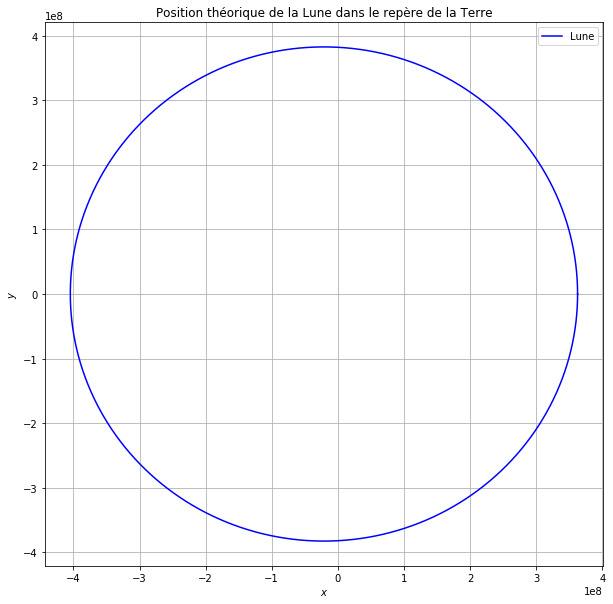

In [16]:
pyplot.figure(figsize=(10,10))
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.plot(xL,yL,'b-', label='Lune')
pyplot.title('Position théorique de la Lune dans le repère de la Terre')
pyplot.legend();
pyplot.show()

Calculons maintenant les paramètres de l'ellipse.

In [17]:
a_theo = L**2/(mu*G*mT*mL*(1-e_theo**2))
b_theo = a_theo*sqrt(1-e_theo**2)
period_theo = 2*pi/sqrt(G*(mT+mL))*a_theo**(3/2)  

print("Demi-grand axe théorique: a =", a_theo, 'm')
print("Demi-petit axe théorique: b =", b_theo, 'm')
print("Excentricité théorique =", e_theo)
print("Période théorique en secondes =", period_theo)
print("Période théorique en jours de 24h =", period_theo/24/3600)

Demi-grand axe théorique: a = 383635471.3593712 m
Demi-petit axe théorique: b = 383058329.53979206 m
Excentricité théorique = 0.05483192491256224
Période théorique en secondes = 2350427.736879297
Période théorique en jours de 24h = 27.20402473239927


Rappelons les valeurs numériques et affichons les différences. Nous remarquons la proximité des résultats.

In [18]:
print("Demi-grand axe numérique: a =", a, 'm. Différence = ', a-a_theo , 'm')
print("Demi-petit axe numérique: b =", b, 'm. Différence = ', b-b_theo , 'm')
print("Excentricité numérique =", e, '. Différence = ', e-e_theo)
print("Période numérique en secondes =", period, '. Différence = ', period-period_theo)
print("Période numérique en jours de 24h =", period/24/3600, '. Différence = ', (period-period_theo)/24/3600)

Demi-grand axe numérique: a = 383635471.359 m. Différence =  1.94311141968e-05 m
Demi-petit axe numérique: b = 383058329.54 m. Différence =  -0.000163078308105 m
Excentricité numérique = 0.0548319249212 . Différence =  8.66097471519e-12
Période numérique en secondes = 2350428 . Différence =  0.2631207029335201
Période numérique en jours de 24h = 27.204027777777778 . Différence =  3.0453785061750007e-06


## Ordre de convergence

Nous nous occupons dans cette section de calculer l'ordre de convergence de la méthode utilisée. La méthode étant celle de Runge et Kutta d'ordre 4, nous cherchons à vérifier que l'ordre vaut bien $4$. Nous aurons pour cela besoin de comparer les erreurs associée au calcul numérique pour plusieurs pas de temps différents.

### Calcul de l'ordre sur base des résultats numériques uniquement

Nous avons besoin d'implémenter une fonction qui quantifie l'erreur sur les résultats de la simulation. Idéalement, ce que nous ferons dans la section suivante, l'erreur se calcule par rapport à la trajectoire limite pour $dt \rightarrow 0$ (i.e. la trajectoire théorique si la méthode converge). Cependant, dans le contexte d'un calcul numérique, la trajectoire théorique n'est généralement pas disponible (d'où l'intérêt de la méthode numérique). Nous comparons dans ce cas les trajectoires à la trajectoire obtenue pour le plus petit $dt$ utilisé, qui approximme alors la trajectoire théorique. Notre fonction de calcul d'erreur prend donc les résultats calculés pour un certain $dt$ ainsi que les données calculées avec le plus petit $dt$ disponible et renvoie la valeur absolue de la différence entre le demi-grand axe des ellipses calculée dans les deux cas, qui nous sert d'indicateur de l'erreur associée à première trajectoire.

In [19]:
def get_diffgrid(data_current, data_fine):
    
    parameters_current = computeParameters(data_current)
    parameters_fine = computeParameters(data_fine)
    
    diffgrid = abs(parameters_current[0]-parameters_fine[0])
    
    return diffgrid  # l'erreur sur la trajectoire de data_current

Calculons maintenant la trajectoire de la Lune pour plusieurs pas de temps différents, afin d'avoir plusieurs trajectoires dont nous pourrons comparer les erreurs. Nous prendrons des $dt$ dans une suite géométrique de raison $r$, le plus petit valant $h$.

In [20]:
r = 2
h = 100
dt_values = numpy.array([h, r*h, r**2*h, r**3*h])

# créons un vecteur stockant les matrices dataLT pour chaque dt
dataLT_values = numpy.empty_like(dt_values, dtype=numpy.ndarray)  

for i, dt in enumerate(dt_values):
    
    # initialisation
    N2 = int(T/dt)+1
    dataLT = numpy.empty((N2, 4))
    dataLT[0] = uLT0
    
    #calcul de la trajectoire
    for t in range(1,N2):
        dataLT[t] = rk4(f, dataLT[t-1], dt)
    
    dataLT_values[i] = dataLT

Calculons les erreurs par rapport à nos données les plus fines grâce à notre fonction get_diffgrid 

In [21]:
diffgridLT = numpy.empty_like(dt_values, dtype=numpy.ndarray)

for i in range(len(dt_values)):
    
    diffgridLT[i] = get_diffgrid(dataLT_values[i], dataLT_values[0])

In [22]:
print(diffgridLT)

[0.0 5.3644180297851562e-07 8.4638595581054688e-06 0.00014746189117431641]


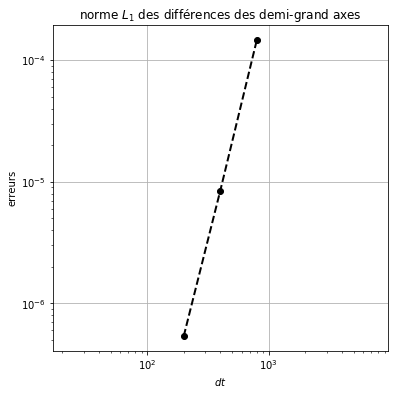

In [23]:
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.title(r'norme $L_1$ des différences des demi-grand axes')
pyplot.xlabel(r'$dt$')
pyplot.ylabel(r'erreurs')
pyplot.xlim(1e-4,1)
pyplot.ylim(1e-4,1)
pyplot.axis('equal')
pyplot.loglog(dt_values[1:], diffgridLT[1:], color='k', ls='--', lw=2, marker='o');

Calculons enfin l'ordre de convergence à partir de ces erreurs. Soient $\alpha$ l'ordre de convergence de la méthode et $dt_1$ et $dt_2 = r\ dt_1$ deux pas de temps utilisés pour calculer la trajectoire. Si $e_1$ est l'erreur sur la trajectoire pour le pas $dt_1$ alors l'erreur pour le pas $dt_2$ est donnée par

$$ e_2 = e_1\ r^{\alpha} $$

Par conséquent, l'ordre $\alpha$ est donné par 

$$ \frac{\ln e_2-\ln e_1}{\ln r} = \frac{\alpha \ln r + \ln e_1-\ln e_1}{\ln r} = \alpha $$

In [24]:
alpha = numpy.empty_like(dt_values[:-2], dtype=numpy.ndarray)

for i in range(1, len(dt_values)-1):
    
    alpha[i-1] = (log(get_diffgrid(dataLT_values[i+1], dataLT_values[i]))\
                  -log(get_diffgrid(dataLT_values[i], dataLT_values[i-1]))) / log(r)

print(alpha)

[3.8853574340588763 4.132069637699308]


Remarque: Notre choix $h=100$ pour le pas de temps le plus fin n'est pas anodin. Nous n'obtenons en réalité pas d'ordre de convergence fixe (ne valant donc pas non plus toujours $4$, loin de là!) pour des pas de temps qui ne sont pas d'ordre de la centaine. Nous ne comprenons pas de phénomène, qui ne semble pas apparaître avec d'autres méthodes de calcul (nous avons testé rk2 et euler). Nous en discutons à la fin de ce travail dans une section dédiée.

### Calcul de l'ordre par comparaison avec la théorie

Nous allons ici calculer les erreurs pour chaque dt en prenant la différence avec la trajectoire théorique

In [25]:
def get_diffgrid_theo(data_current):
    
    parameters_current = computeParameters(data_current)
    
    diffgrid = abs(parameters_current[0]-a_theo)
        
    return diffgrid

In [26]:
r = 2
h = 100
dt_values = numpy.array([h, r*h, r**2*h, r**3*h])

dataLT_values = numpy.empty_like(dt_values, dtype=numpy.ndarray)

for i, dt in enumerate(dt_values):
    
    N2 = int(T/dt)+1
    dataLT = numpy.empty((N2, 4))
    dataLT[0] = uLT0

    for t in range(1,N2):
        dataLT[t] = rk4(f, dataLT[t-1], dt)
    
    dataLT_values[i] = dataLT

In [27]:
diffgridLT = numpy.empty_like(dt_values, dtype=numpy.ndarray)

for i in range(len(dt_values)):
    
    diffgridLT[i] = get_diffgrid_theo(dataLT_values[i])

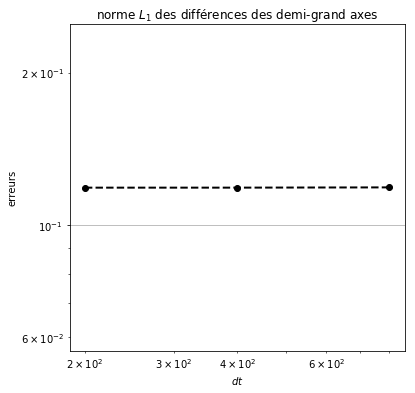

In [28]:
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.title(r'norme $L_1$ des différences des demi-grand axes')
pyplot.xlabel(r'$dt$')
pyplot.ylabel(r'erreurs')
pyplot.xlim(1e-4,1)
pyplot.ylim(1e-4,1)
pyplot.axis('equal')
pyplot.loglog(dt_values[1:], diffgridLT[1:], color='k', ls='--', lw=2, marker='o');

In [29]:
alpha = numpy.empty_like(dt_values[:-1], dtype=numpy.ndarray)

for i in range(len(dt_values)-1):
    
    #alpha[i-1] = (log(diffgridLT[i+1])-log(diffgridLT[i])) / log(r)
    alpha[i] = (log(get_diffgrid_theo(dataLT_values[i+1]))\
                  -log(get_diffgrid_theo(dataLT_values[i]))) / log(r)

print(alpha)

[6.532523174381745e-06 9.6532727597379e-05 0.0016915402108337665]


Remarque: Les valeurs absurdes obtenues proviennent du même problème que celui mentioné dans la méthode numérique. Ici, nous n'arrivons même pas à trouver une valeur de $dt$ qui donnent un ordre proche de $4$. En modifiant le pas de temps pour tester d'autres valeurs, nous remarquons que les erreurs sur les trajectoires sont fréquemment les mêmes pour des $dt$ proches mais pourtant différents. Il semble donc que la méthode de Runge-Kutta 4 appliquée à notre problème converge "par paliers". Nous pouvons déjà observer ce phénomène sur les valeurs obtenues pour les erreurs entre nos trois premiers $dt$. En effet, les deux premières valeurs du vecteur "diffgridLT" sont quasiment identiques. Cette "convergence par palier n'apparaît pas pour les méthodes d'Euler et Runge-Kutta 2.

In [30]:
print(diffgridLT)

[0.11847186088562012 0.1184723973274231 0.11848032474517822
 0.11861932277679443]


## Système Terre - Lune - astéroïde

Nous ajoutons maintenant un astéroïde au centre de l'ellipse et analysons sa trajectoire.

### Calcul des trajectoires

La nouvelle fonction "d'évolution" du système doit maintenant faire évoluer le vecteur $u_{AT} = (x_{AT},y_{AT},v_{x\,AT},v_{y\,AT})$ des coordonnées de l'astéroïde dans le repère de la Terre. Nous négligeons l'influence de l'astéroïde sur l'évolution du vecteur $u_{LT}$ de la Lune qui restera donc inchangée. 

La force gravitationnelle agissant sur l'astéroïde se sépare en deux contributions: l'attraction de la Terre et celle de la Lune. Avec les notations introduites précédemment, nous pouvons écrire l'accélération de l'astéroïde dans le repère de la Terre comme 

$$ {\bf \ddot{r}_{AT}} = -G(m_T+m_A)\dfrac{{\bf r_{AT}}}{r_{AT}^3} - G m_L\dfrac{{\bf r_{AT}}-{\bf r_{LT}}}{(r_{AT}-r_{LT})^3}$$

Expression dont nous avons déjà décrit l'obtention du premier terme dans le cas de l'attraction Terre-Lune. Le deuxième terme n'est que l'expression de la simple attraction newtonienne de deux masses. Nous négligeons dans nos calculs la masse $m_A$ de l'astéroïde pour obtenir

$$ {\bf \ddot{r}_{AT}} \approx -G m_T\dfrac{{\bf r_{AT}}}{r_{AT}^3} - G m_L\dfrac{{\bf r_{AT}}-{\bf r_{LT}}}{(r_{AT}-r_{LT})^3}$$

In [31]:
def f_ast(uLT,uAT): 
    out = numpy.empty((2,4))  
    out[0] = numpy.array([uLT[2],\
                          uLT[3],\
                          -G*(mT+mL)*uLT[0]/(uLT[0]**2+uLT[1]**2)**(3/2),\
                          -G*(mT+mL)*uLT[1]/(uLT[0]**2+uLT[1]**2)**(3/2)])
    out[1] = numpy.array([uAT[2],\
                          uAT[3],\
                          -G*mT*uAT[0]/(uAT[0]**2+uAT[1]**2)**(3/2) + \
                          -G*mL*(uAT[0]-uLT[0])/((uAT[0]-uLT[0])**2+(uAT[1]-uLT[1])**2)**(3/2),\
                          -G*mT*uAT[1]/(uAT[0]**2+uAT[1]**2)**(3/2) + \
                          -G*mL*(uAT[1]-uLT[1])/((uAT[0]-uLT[0])**2+(uAT[1]-uLT[1])**2)**(3/2)])
    return out

Nous avons précédemment trouvé l'instant où la Lune est à l'apogée de sa trajectoire autour de la Terre. Nous pouvons donc entrer nos conditions initiales. Notons qu'il y a ambiguïté sur les conditions initiales données dans l'énoncé. La vitesse initiale de l'astéroïde est donnée comme étant $(v_x,v_y)=(-500{\rm m/s},500 {\rm m/s})$ *sans qu'il ne soit précisé dans quel repère il s'agit*. Suivant que nous choisissons de faire démarrer la Lune dans les $x$ négatifs ou positifs, avec une vitesse négative ou positive selon $y$, ou encore de faire démarrer la Lune avec un angle quelconque par rapport à l'axe $x$, nous obtenons des résultats différents pour la trajectoire de l'astéroïde. 

In [32]:
T = 3600*24*14
dt = 1
N = 1+int(T/dt)

mT = 5.972*10**24
mL = 7.348*10**22
G = 6.67408*10**-11

dataLT = numpy.empty((N,4)) 
dataAT = numpy.empty((N,4)) 

uAT0 = [Xcenter, Ycenter,-500,500]

dataLT[0] = uLT_apogee
dataAT[0] = uAT0

print(uAT0)

[-21035471.359390616, 6.9081783294677734e-05, -500, 500]


Réécrivons la méthode de Runge-Kutta

In [33]:
def rk4_ast(f_ast,uLT,uAT,dt): 
    k1 = f_ast(uLT,uAT)
    k2 = f_ast(uLT+dt/2*k1[0,:],uAT+dt/2*k1[1,:])
    k3 = f_ast(uLT+dt/2*k2[0,:],uAT+dt/2*k2[1,:])
    k4 = f_ast(uLT+dt*k3[0,:],uAT+dt*k3[1,:])
    
    out = numpy.empty((2,4))
    out[0] = uLT+dt/6*(k1[0,:]+2*k2[0,:]+2*k3[0,:]+k4[0,:])
    out[1] = uAT+dt/6*(k1[1,:]+2*k2[1,:]+2*k3[1,:]+k4[1,:])
    
    return out

Calculons la trajectoire

In [34]:
for t in range(1,N):
    
    temp = rk4_ast(f_ast,dataLT[t-1],dataAT[t-1],dt)
    dataLT[t] = temp[0]
    dataAT[t] = temp[1]

Affichons la trajectoire

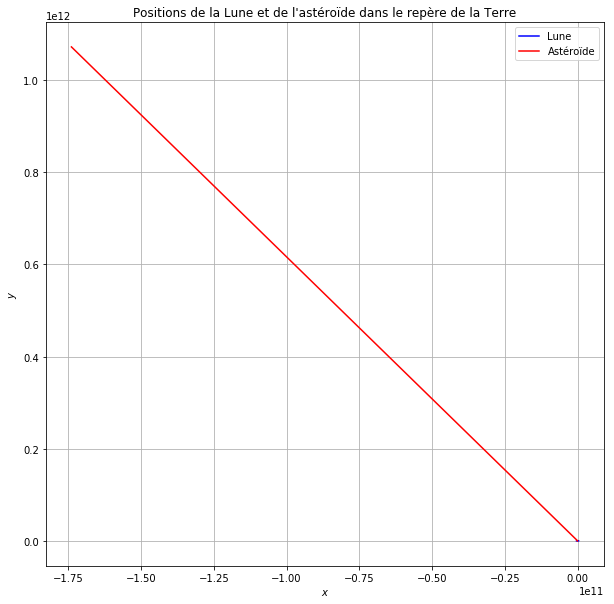

In [35]:
pyplot.figure(figsize=(10,10))
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.plot(dataLT[:,0],dataLT[:,1], 'b-', label='Lune')
pyplot.plot(dataAT[:,0],dataAT[:,1], 'r-', label='Astéroïde')
pyplot.title('Positions de la Lune et de l\'astéroïde dans le repère de la Terre')
pyplot.legend();
pyplot.show();

Nous remarquons que l'astéroïde passe très près de la Terre. Après quelques révolutions, l'astéroïde se fait éjecter du champ gravitationnele de la Terre. Cela est dû à sa faible vitesse initiale qui l'empêche de garder une bonne distance avec la Terre. En réalité, si nous prenons en compte le rayon de la Terre, nous verrions qu'il y a collision avec l'astéroïde. C'est ce que nous allons montrer dans la section suivante. Le passage près de la Terre est assez délicat pour le calcul numérique, nous en discutons dans une section dédiée à la fin de ce travail.

Nous pouvons afficher la position de l'astéroïde après 14 jours.

In [36]:
print('Position après 14 jours sur l\'axe x: ', dataAT[-1,0], 'm')
print('Position après 14 jours sur l\'axe y: ', dataAT[-1,1], 'm')

Position après 14 jours sur l'axe x:  -173921423423.0 m
Position après 14 jours sur l'axe y:  1.07178425236e+12 m


### Description de l'impact entre l'astéroïde et la Terre

Nous commençons par encoder le rayon de la Terre

In [37]:
radiusT = 6370000

Nous cherchons ensuite l'instant de collision

In [38]:
indexImpact = 0

for t in range(1,N):
    
    if (dataAT[t,0]**2+dataAT[t,1]**2)<=radiusT**2:
        
        indexImpact = t
        break
        
print('Temps écoulé avant l\'impact =', indexImpact*dt, 'secondes')

Temps écoulé avant l'impact = 5608 secondes


Nous trouvons le point d'impact

In [39]:
print('Point d\'impact: x =', dataAT[indexImpact,0], 'm, y =', dataAT[indexImpact,1], 'm')

Point d'impact: x = -6151491.52097 m, y = 1652872.22716 m


Nous trouvons la norme de la vitesse d'impact

In [40]:
print('Vitesse d\'impact: v =', sqrt(dataAT[indexImpact,2]**2+dataAT[indexImpact,3]**2), 'm/s')

Vitesse d'impact: v = 9367.567398403384 m/s


## Animations

### Animation des trajectoires pour le système Terre-Lune

In [41]:
from matplotlib import animation
from IPython.display import HTML

Nous prendrons un pas de temps plus grand pour que la vidéo ne soit pas trop lourde. La précision n'est pas indispensable pour faire l'animation, à condition que le comportement obtenu soit fidèle à celui obtenu pour de petits pas de temps.

In [42]:
T = 3600*24*30
dt = 30000
N = 1+int(T/dt)

In [43]:
dataLT = numpy.empty((N,4)) 

dataLT[0] = uLT0

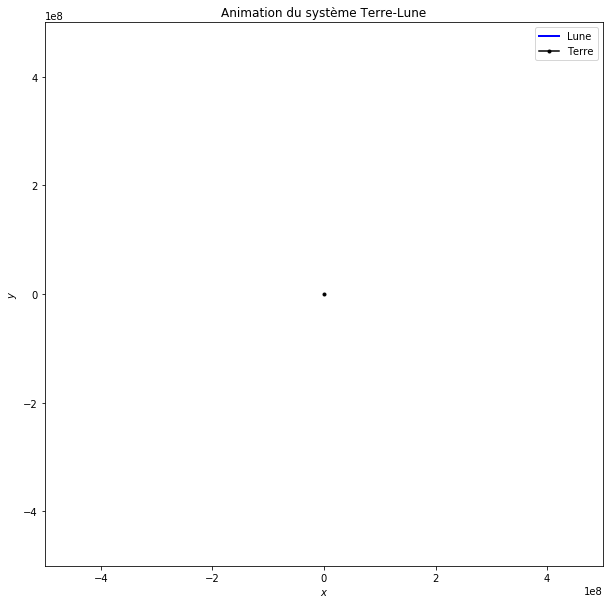

In [44]:
fig = pyplot.figure(figsize=(10,10))
ax = pyplot.axes(xlim=(-500000000,500000000), ylim=(-500000000,500000000))
line = ax.plot([], [], color='b', ls='-', label='Lune', lw=2)[0]
pointT=[[0,0]]
point = ax.plot(*zip(*pointT), marker='o', color='k', markersize=3, label='Terre')
pyplot.title('Animation du système Terre-Lune')
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.legend();

In [45]:
def trajectory(i):
    
    line.set_data(dataLT[:i,0], dataLT[:i,1])
    
    dataLT[i+1] = rk4(f,dataLT[i],dt)

In [46]:
anim = animation.FuncAnimation(fig, trajectory,
                               frames=N-1, interval=100)

In [47]:
HTML(anim.to_html5_video())

### Animation des trajectoires pour le système Terre-Lune-Astéroïde

Nous animerons ici que la trajectoire de l'astéroïde, la trajectoire de la Lune restant la même par hypothèse. Comme nous sommes ici forcés de prendre un $dt$ très petit et que les animations prennent du temps à compiler, nous n'affichons qu'une frame toutes les 100 boucles. Ceci est adaptable avec la variable $M$. Nous animerons la trajectoire que sur une seule révolution.

In [48]:
# T = 3600*24*4   pour animer jusqu'à l'éjection (prendre alors M=1000 un peu plus loin)
T = 3600*4
dt = 1
N = 1+int(T/dt)

In [49]:
dataLT = numpy.empty((N,4)) 
dataAT = numpy.empty((N,4)) 

dataLT[0] = uLT_apogee
dataAT[0] = uAT0

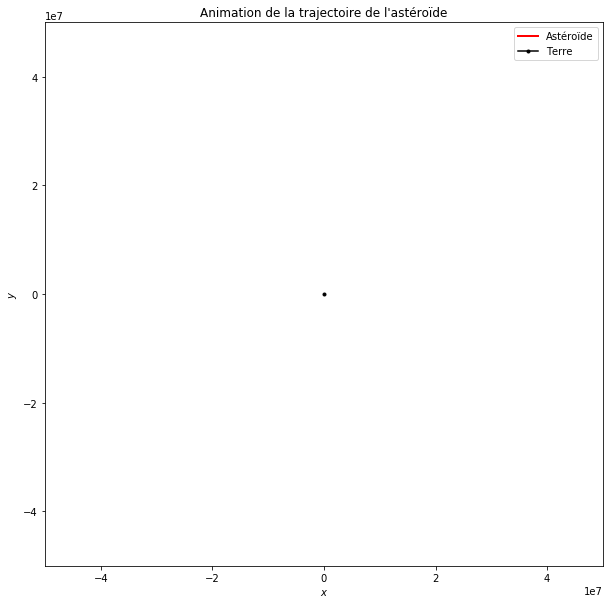

In [50]:
fig = pyplot.figure(figsize=(10,10))
ax = pyplot.axes(xlim=(-50000000,50000000), ylim=(-50000000,50000000))
lineA = ax.plot([], [], color='r', ls='-', lw=2, label='Astéroïde')[0]
pointT=[[0,0]]
point = ax.plot(*zip(*pointT), marker='o', color='black', markersize=3, label='Terre')  # évidemment pas à l'échelle!
pyplot.title('Animation de la trajectoire de l\'astéroïde')
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.legend();

In [51]:
def trajectory_ast(i):
    
    lineA.set_data(dataAT[:i,0],dataAT[:i,1])
    
    temp = rk4_ast(f_ast,dataLT[i],dataAT[i],dt)
    dataLT[i+1] = temp[0]
    dataAT[i+1] = temp[1]

In [52]:
# ne met à jour "lineA" qu'une fois sur M
M = 100

def trajectory_ast(i):
    
    lineA.set_data(dataAT[:i*M,0],dataAT[:i*M,1])
    
    for j in range(M):
        
        temp = rk4_ast(f_ast,dataLT[i*M+j],dataAT[i*M+j],dt)
        dataLT[i*M+j+1] = temp[0]
        dataAT[i*M+j+1] = temp[1]

In [53]:
anim_ast = animation.FuncAnimation(fig, trajectory_ast,
                               frames=int((N-1)/M), interval=int(M/2))

In [54]:
HTML(anim_ast.to_html5_video())

Remarque: L'astéroïde ne revient pas à sa position initiale. Ceci est dû au même problème que celui énoncé précédemment: le potentiel varie trop à l'origine et les $dt$ de l'ordre de l'unité ne suffisent pas pour reproduire la trajectoire théorique. 

## Investigations supplémentaires

### Etude du passage de l'astéroïde près de la Terre

Le passage de l'astéroïde près de la Terre est assez délicat et peu être drastiquement différent pour peu que le pas de temps $dt$ ne soit pas assez grand. Pour des $dt$ un peu plus grand, nous observons que l'astéroïde quitte brusquement l'influence gravitationnelle de la Terre alors qu'il est beaucoup plus près de celle-ci que l'est la Lune et que la norme de sa vitesse est icomparable à celle de la Lune. Nous voyons dans la section suivante que l'astéroïde passe très près de la Terre et qu'en réalité, nous devrions avoir un impact entre l'astéroïde et la Terre. Nous suspectons que le passage près de $r=0$ fait que la valeur de l'attraction gravitationnelle, en $1/r$, "explose" au passage près de l'origine. Une incrémentation de temps plus tard, l'algorithme calcule une position pour l'astéroïde assez éloignée de l'origine et une vitesse trop grande de sorte que l'astéroïde ait assez d'énergie pour quitter l'influence de la Terre.

Calculons la trajectoire de l'astéroïde avec $dt=10$ secondes. Prendre un pas de temps plus grand accentuera le phénomène qui sera visible dès la première révolution.

In [55]:
T = 3600*2
dt = 10
N = 1+int(T/dt)

mT = 5.972*10**24
mL = 7.348*10**22
G = 6.67408*10**-11

dataLT = numpy.empty((N,4)) 
dataAT = numpy.empty((N,4)) 

uAT0 = [Xcenter, Ycenter,-500,500]

dataLT[0] = uLT_apogee
dataAT[0] = uAT0

print(uAT0)

[-21035471.359390616, 6.9081783294677734e-05, -500, 500]


In [56]:
for t in range(1,N):
    
    temp = rk4_ast(f_ast,dataLT[t-1],dataAT[t-1],dt)
    dataLT[t] = temp[0]
    dataAT[t] = temp[1]

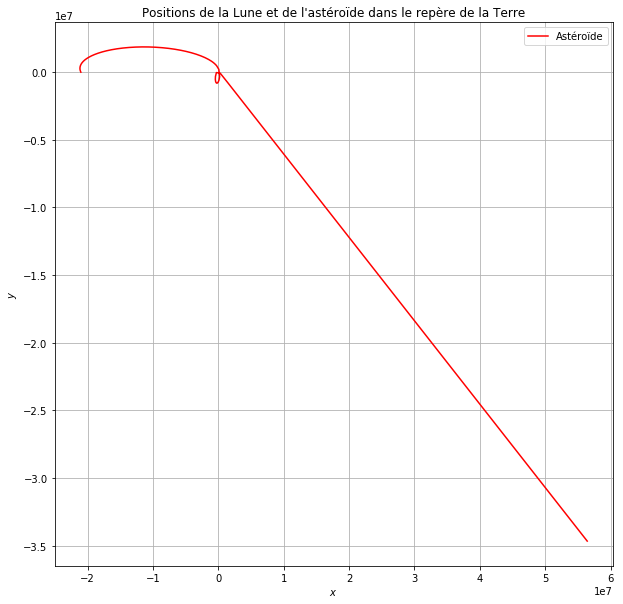

In [57]:
pyplot.figure(figsize=(10,10))
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
#pyplot.plot(dataLT[:,0],dataLT[:,1], 'b-', label='Lune')
pyplot.plot(dataAT[:,0],dataAT[:,1], 'r-', label='Astéroïde')
pyplot.title('Positions de la Lune et de l\'astéroïde dans le repère de la Terre')
pyplot.legend();
pyplot.show();

Nous commençons par chercher le point de passage le plus proche de la Terre. 

In [58]:
indexClosest = 0

distMin2 = numpy.min(dataAT[:,0]**2+dataAT[:,1]**2)

for t in range(1,N):
    
    if (dataAT[t,0]**2+dataAT[t,1]**2)==distMin2:
        
        indexClosest = t
        break
        
print('Moment de passage au plus près de la Terre =', indexClosest*dt, 'secondes')

Moment de passage au plus près de la Terre = 6040 secondes


Nous voyons en affichant le vecteur $u_{AT}$ que les caractéristiques de l'astéroïde fluctuent beaucoup à l'approche de la Terre. Un effet de ces changements trop important est que l'astéroïde est éloigné rapidement de la Terre avec une énergie beaucoup trop grande. Il quitte donc l'influence terrestre.

In [59]:
t = indexClosest

print('uAT avant =', dataAT[t-1,:])
print('uAT à cet instant =', dataAT[t,:])
print('uAT après =', dataAT[t+1,:])

uAT avant = [-286785.27163058  489325.79610862   32195.83384096  -18261.69252233]
uAT à cet instant = [  69700.51812934  210081.1980674    33030.46861332  -50071.89415772]
uAT après = [ 195062.15837017 -335447.24598266   -6367.77551853  -34700.53261021]


In [60]:
print('distance à la Terre avant = ', numpy.sqrt(dataAT[t-1,0]**2+dataAT[t-1,1]**2)/radiusT, 'rayons terrestres')
print('distance à la Terre à cet instant = ', numpy.sqrt(dataAT[t,0]**2+dataAT[t,1]**2)/radiusT, 'rayons terrestres')
print('distance à la Terre après = ', numpy.sqrt(dataAT[t+1,0]**2+dataAT[t+1,1]**2)/radiusT, 'rayons terrestres')

distance à la Terre avant =  0.0890381911374 rayons terrestres
distance à la Terre à cet instant =  0.0347475635433 rayons terrestres
distance à la Terre après =  0.0609166071147 rayons terrestres


Nous voyons ici la valeur beaucoup trop élevée de l'énergie après le passage près de la Terre

In [61]:
Energy0 = 1/2*(uAT0[2]**2+uAT0[3]**2) - G*mT/numpy.sqrt(uAT0[0]**2+uAT0[1]**2)\
            - G*mL/numpy.sqrt((uAT0[0]-uLT_apogee[0])**2+(uAT0[1]-uLT_apogee[1])**2)
EnergytBefore = 1/2*(dataAT[t-1,2]**2+dataAT[t-1,3]**2) - G*mT/numpy.sqrt(dataAT[t-1,0]**2+dataAT[t-1,1]**2)\
            - G*mL/numpy.sqrt((dataAT[t-1,0]-dataLT[t-1,0])**2+(dataAT[t-1,1]-dataLT[t-1,1])**2)
Energyt = 1/2*(dataAT[t,2]**2+dataAT[t,3]**2) - G*mT/numpy.sqrt(dataAT[t,0]**2+dataAT[t,1]**2)\
            - G*mL/numpy.sqrt((dataAT[t,0]-dataLT[t,0])**2+(dataAT[t,1]-dataLT[t,1])**2)
EnergytAfter = 1/2*(dataAT[t+1,2]**2+dataAT[t+1,3]**2) - G*mT/numpy.sqrt(dataAT[t+1,0]**2+dataAT[t+1,1]**2)\
            - G*mL/numpy.sqrt((dataAT[t+1,0]-dataLT[t+1,0])**2+(dataAT[t+1,1]-dataLT[t+1,1])**2)


print('Energie totale initiale =', Energy0, ' Joules par kg')

print('Energie totale avant =', EnergytBefore/Energy0, ' fois l\'energie totale initiale')
print('Energie totale à cet instant =', Energyt/Energy0, ' fois l\'energie totale initiale')
print('Energie totale après =', EnergytAfter/Energy0, ' fois l\'energie totale initiale')

Energie totale initiale = -18710590.5566  Joules par kg
Energie totale avant = 0.947207473685  fois l'energie totale initiale
Energie totale à cet instant = 0.087329750686  fois l'energie totale initiale
Energie totale après = 21.6363853476  fois l'energie totale initiale


Nous voyons dans cette section que près de l'origine, le potentiel en $1/r$ varie beaucoup trop pour que des pas de temps raisonablement petits ($dt > \sim 1$) puisse reproduire la trajectoire avec précision. 

Remarque: Il serait intéressant de développer un algorithme qui détecte l'intensité de la dérivée du potentiel à adapte localement le pas de temps $dt$ afin de toujours avoir un $dt$ suffisament petit pour reproduire la trajectoire.

## Trajectoire pour un astéroïde plus rapide 

Le problème étant que la vitesse initiale de l'astéroïde est trop faible pour que celui-ci puisse maintenir une bonne distance avec l'origine, observons la trajectoire d'un astéroïde dont la vitesse initiale est plus grande.

In [62]:
T = 3600*24*27.2*5
# dt=10
dt = 100
N = 1+int(T/dt)

mT = 5.972*10**24
mL = 7.348*10**22
G = 6.67408*10**-11

dataLT = numpy.empty((N,4)) 
dataAT = numpy.empty((N,4)) 

uAT0 = [Xcenter, Ycenter,-4000,4000]

dataLT[0] = uLT_apogee
dataAT[0] = uAT0

In [63]:
for t in range(1,N):
    
    temp = rk4_ast(f_ast,dataLT[t-1],dataAT[t-1],dt)
    dataLT[t] = temp[0]
    dataAT[t] = temp[1]

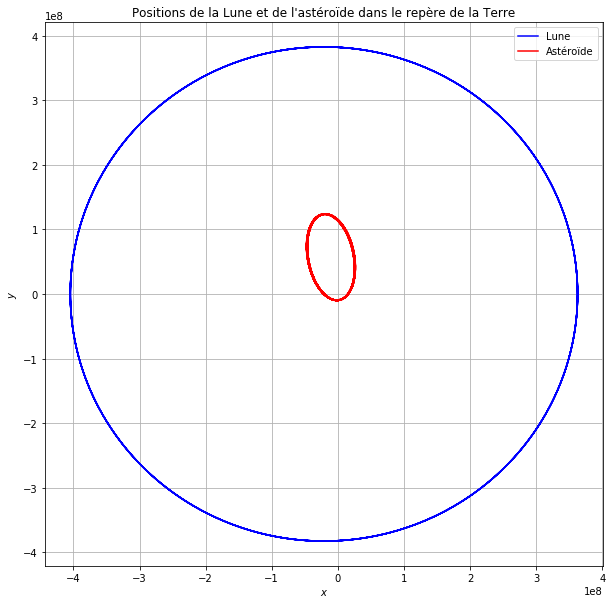

In [64]:
pyplot.figure(figsize=(10,10))
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.plot(dataLT[:,0],dataLT[:,1], 'b-', label='Lune')
pyplot.plot(dataAT[:,0],dataAT[:,1], 'r-', label='Astéroïde')
pyplot.title('Positions de la Lune et de l\'astéroïde dans le repère de la Terre')
pyplot.legend();
pyplot.show();

Nous voyons que la trajectoire, qui ne passe pas aussi près de l'origine, n'est pas soudainement déviée. Nous remarquons également que les traits rouges de la trajectoire de l'astéroïde semblent être assez épais. Nous suspectons que cela n'est pas dû à une imprécision numérique mais qu'il s'agisse d'un véritable effet physique causé par l'attraction de la Lune. Nous allons le montrer en analysant les points de passage de l'astéroïde sur l'axe des $x$.

Détectons le nombre de passages sur l'axe des $x$ en direction des $y$ positifs. Cela nous évitera de faire de l'allocation dynamique.

In [65]:
number_crossings = 0

for t in range(1,N):
    
    if dataAT[t,1]>=0 and dataAT[t-1,1]<0:
        
        number_crossings = number_crossings+1

Calculons les points de passage

In [66]:
t_crossings = numpy.zeros((number_crossings))
count = 0

for t in range(1,N):
    
    if dataAT[t,1]>=0 and dataAT[t-1,1]<0:
        
        t_crossings[count] = t
        count = count+1

x_crossings = numpy.zeros((number_crossings))
deltas_x = numpy.zeros((number_crossings-1))

for i in range(len(t_crossings)):
    
    x_crossings[i] = dataAT[int(t_crossings[i]),0]
    if i>0:
        deltas_x[i-1] = x_crossings[i] - x_crossings[i-1]

Affichons les coordonnées $x$ de passage en fonction du temps dans un graphique

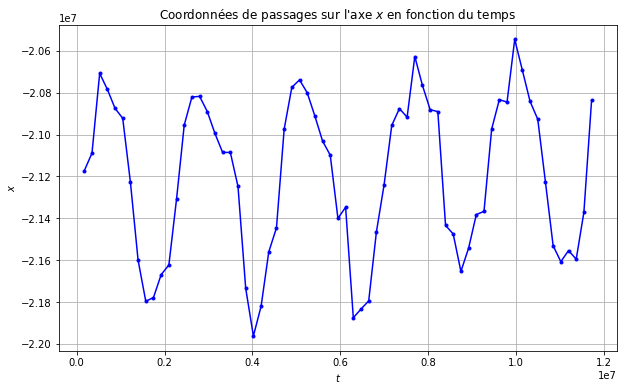

In [67]:
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$t$')
pyplot.ylabel('$x$')
pyplot.plot(t_crossings*dt,x_crossings, 'b-', marker='.')
pyplot.title('Coordonnées de passages sur l\'axe $x$ en fonction du temps')
pyplot.show();

Nous voyons que la Lune fait périodiquement dévier la trajectoire de l'astéroïde. L'oscillation est plus lisse pour de plus petits $dt$. De plus, en prenant des $dt$ plus fin (remplacer $dt = 10$), nous observons que la position moyenne de passage dérive. Nous avons réalisé le calcul sur deux ans et ce taux de dérive semble être fixe avec une valeur de $0.020$ m/s. Nous ne savons pas encore à quoi cela peut être dû, cela pourrait être causé par des erreurs numériques mais le taux semble rester fixe quel que soit le $dt$ utilisé.

### Ordre de convergence pour la méthode d'Euler

In [68]:
def euler(f,uLT,dt):
    
    return uLT + dt*f(uLT)

In [69]:
r = 2
h = 10
dt_values = numpy.array([h, r*h, r**2*h, r**3*h])

dataLT_values = numpy.empty_like(dt_values, dtype=numpy.ndarray)  

for i, dt in enumerate(dt_values):
    
    N2 = int(T/dt)+1
    dataLT = numpy.empty((N2, 4))
    dataLT[0] = uLT0
    
    for t in range(1,N2):
        dataLT[t] = euler(f, dataLT[t-1], dt)
    
    dataLT_values[i] = dataLT

In [70]:
diffgridLT = numpy.empty_like(dt_values, dtype=numpy.ndarray)

for i in range(len(dt_values)):
    
    diffgridLT[i] = get_diffgrid_theo(dataLT_values[i])

In [71]:
print(diffgridLT)

[555601.49015522003 1110823.8089581728 2220135.0544080734
 4434255.1583669186]


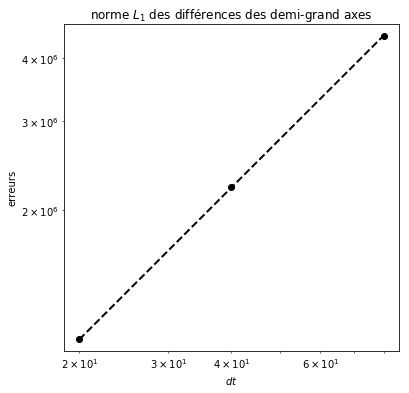

In [72]:
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.title(r'norme $L_1$ des différences des demi-grand axes')
pyplot.xlabel(r'$dt$')
pyplot.ylabel(r'erreurs')
pyplot.xlim(1e-4,1)
pyplot.ylim(1e-4,1)
pyplot.axis('equal')
pyplot.loglog(dt_values[1:], diffgridLT[1:], color='k', ls='--', lw=2, marker='o');

In [73]:
alpha = numpy.empty_like(dt_values[:-2], dtype=numpy.ndarray)

for i in range(1, len(dt_values)-1):
    
    alpha[i-1] = (log(get_diffgrid(dataLT_values[i+1], dataLT_values[i]))\
                  -log(get_diffgrid(dataLT_values[i], dataLT_values[i-1]))) / log(r)

print(alpha)

[0.9985267394514613 0.9970692755527135]


Nous pouvons voir avec encore d'autres pas de temps que le calcul de l'ordre ne pose pas problème pour la méthode d'euler.

### Ordre de convergence pour la méthode de Runge et Kutta d'ordre 2

In [74]:
def rk2(f,uLT,dt):
    
    k1 = f(uLT)
    k2 = f(uLT+dt/2*k1)
    
    return uLT + dt*k2

In [75]:
r = 2
h = 1000
dt_values = numpy.array([h, r*h, r**2*h, r**3*h])

dataLT_values = numpy.empty_like(dt_values, dtype=numpy.ndarray)  

for i, dt in enumerate(dt_values):
    
    N2 = int(T/dt)+1
    dataLT = numpy.empty((N2, 4))
    dataLT[0] = uLT0
    
    for t in range(1,N2):
        dataLT[t] = rk2(f, dataLT[t-1], dt)
    
    dataLT_values[i] = dataLT

In [76]:
diffgridLT = numpy.empty_like(dt_values, dtype=numpy.ndarray)

for i in range(len(dt_values)):
    
    diffgridLT[i] = get_diffgrid_theo(dataLT_values[i])

In [77]:
print(diffgridLT)

[927.22292590141296 3736.6220970153809 15343.845239162445
 60340.658794522285]


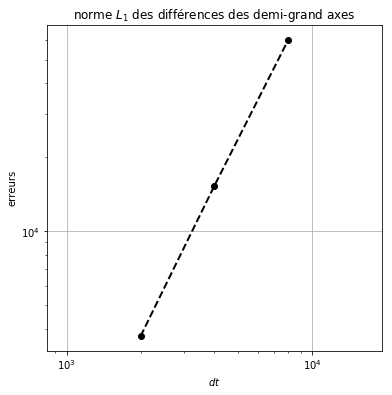

In [78]:
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.title(r'norme $L_1$ des différences des demi-grand axes')
pyplot.xlabel(r'$dt$')
pyplot.ylabel(r'erreurs')
pyplot.xlim(1e-4,1)
pyplot.ylim(1e-4,1)
pyplot.axis('equal')
pyplot.loglog(dt_values[1:], diffgridLT[1:], color='k', ls='--', lw=2, marker='o');

In [79]:
alpha = numpy.empty_like(dt_values[:-2], dtype=numpy.ndarray)

for i in range(1, len(dt_values)-1):
    
    alpha[i-1] = (log(get_diffgrid(dataLT_values[i+1], dataLT_values[i]))\
                  -log(get_diffgrid(dataLT_values[i], dataLT_values[i-1]))) / log(r)

print(alpha)

[2.0466893416086385 1.9547999709025654]


Nous pouvons voir avec encore d'autres pas de temps que le calcul de l'ordre ne pose pas problème non plus pour la méthode de Runge-Kutta d'ordre 2.

Vu que le calcul de l'ordre va pour plusieurs autres méthodes, le problème semble être spécifique à la méthode de Runge-Kutta d'ordre 4.

### Temps d'excécution total du notebook

In [80]:
t1 = time.time()

print('Temps d\'exécution total du notebook en secondes =', t1-t0)
print('Temps d\'exécution total du notebook en minutes =', (t1-t0)/60)

Temps d'exécution total du notebook en secondes = 239.5749213695526
Temps d'exécution total du notebook en minutes = 3.99291535615921
